## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [0]:
import string

In [0]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

--2020-04-30 10:29:38--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119747 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.01s   

2020-04-30 10:29:39 (9.00 MB/s) - ‘sonnets.txt’ saved [119747/119747]



In [0]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [0]:
text = [x.lower() for x in text]

text = ''.join(text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [0]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [0]:
# dict <index>:<char>
# Your great code here

token_to_idx = dict((x, i) for i, x in enumerate(tokens))

idx_to_token = dict((y, x) for (x, y) in token_to_idx.items())
# dict <char>:<index>
# Your great code here

In [0]:
dict_size = len(token_to_idx)
dict_size

38

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [0]:
import torch
from torch import nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F
%matplotlib inline

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [0]:
def to_DataLoader_for_emb_new(text, seq_len, token_to_idx, batch_size):
  target = text[1:]
  but_text = []
  for i in range(len(text) // seq_len):
    but_text.append([torch.tensor(text[i*seq_len:(i+1)*seq_len], dtype=torch.long), torch.tensor(target[i*seq_len:(i+1)*seq_len], dtype=torch.long)])

  trainloader = torch.utils.data.DataLoader(but_text, shuffle=False, batch_size=batch_size)
  return trainloader

In [0]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_dim, emb_dim, n_layers=1):
      super(SimpleRNN, self).__init__()

      self.hid_dim = hidden_dim
      self.emb_dim = emb_dim

      self.emb = nn.Embedding(input_size,
                              emb_dim)
      
      self.out = nn.Linear(
          in_features=hidden_dim, 
          out_features=input_size) 
            
      self.rnn = nn.GRU(
            input_size=emb_dim,
            hidden_size=hidden_dim, 
            batch_first=True
        )
        
    def forward(self, input, hidden):
        if (len(input.shape) == 1):
          input = input.unsqueeze(0)
        
        input_sized = self.emb(input)

        output, hidden = self.rnn(input_sized, hidden)
        prediction = self.out(output)

        return prediction, hidden

    def initial_state(self, batch_size, device):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.hid_dim, requires_grad=True,  device=device)


class RnnLSTM(nn.Module):
    def __init__(self, input_size, hidden_dim,  emb_dim, n_layers=1):
      super(RnnLSTM, self).__init__()

      self.hid_dim = hidden_dim

      self.emb = nn.Embedding(input_size,
                              emb_dim)
        
      self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        
      self.out = nn.Linear(
          in_features=hidden_dim, 
          out_features=input_size)
        
    def forward(self, input, hidden):
        if (len(input.shape) == 1):
          input = input.unsqueeze(0)
        
        input_sized = self.emb(input)

        output, hidden = self.rnn(input_sized, hidden)
        prediction = self.out(output)

        return prediction, hidden

        return prediction, hidden
    def initial_state(self, batch_size, device):
        """ return rnn state before it processes first input (aka h0) """
        return (torch.zeros(1, batch_size, self.hid_dim, requires_grad=True,  device=device), 
                torch.zeros(1, batch_size, self.hid_dim, requires_grad=True, device=device))

In [0]:
text_nums = [token_to_idx[x] for x in text]

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [0]:
def train(model, criterion, optimizer, dataloader, batch_size, dict_size, device, n_epochs):
    history = []
    model = model.to(device)
    
    model.train()

    for epoch in range(n_epochs):
        
        batch_loss = 0
        i = 0

        for X, target in dataloader:

          hidden = model.initial_state(X.shape[0], device)

          X, target = X.to(device), target.to(device)
       
          optimizer.zero_grad()

          output, _ = model(X, hidden)

          output = output.to(device)
    
          loss = criterion(output.contiguous().view(-1, dict_size),
                           target.contiguous().view(-1))

          batch_loss = batch_loss + loss
          i = i + 1

          loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
          optimizer.step() # Updates the weights accordingly

        batch_loss = batch_loss / i

        history.append(batch_loss.data.item())
        if (epoch) % 10 == 0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()
        
        if epoch % 10 == 0:
            print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
            print("Loss: {:.4f}".format(batch_loss.item()))
    return model

In [0]:
EPOCH = 500
BATCH_SIZE = 10
HIDDEN_DIM = 64
MAX_LENGTH = 256
SEQ_SIZE = 256
EMB_DIM = 38

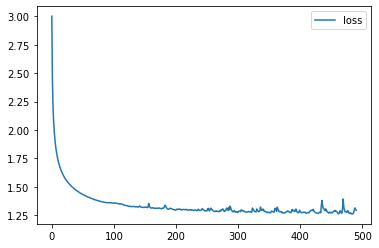

Epoch: 490/500............. Loss: 1.2920


SimpleRNN(
  (emb): Embedding(38, 38)
  (out): Linear(in_features=64, out_features=38, bias=True)
  (rnn): GRU(38, 64, batch_first=True)
)

In [51]:
dataLoader = to_DataLoader_for_emb_new(text_nums, SEQ_SIZE, token_to_idx, BATCH_SIZE)
char_rnn = SimpleRNN(dict_size, HIDDEN_DIM, EMB_DIM)
criterion = nn.CrossEntropyLoss()
opt =  torch.optim.Adam(char_rnn.parameters(), lr=0.002)
train(char_rnn, criterion, opt, dataLoader, BATCH_SIZE, dict_size, device, EPOCH)

In [0]:
def generate_sample(char_rnn, device, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    seed_phrase = seed_phrase.lower()

    with torch.no_grad(): 
      # x_sequence = [to_one_hot(token_to_idx[token]) for token in seed_phrase]
      x_sequence = [torch.tensor(token_to_idx[token]).squeeze(0) for token in seed_phrase]
      x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
      x_sequence = x_sequence.to(device)
      hid_state = char_rnn.initial_state(1, device)
      
      #feed the seed phrase, if any
      for i in range(len(seed_phrase) - 1):
          out, hid_state = char_rnn(x_sequence[:, i], hid_state)

      
      #start generating
      for _ in range(max_length - len(seed_phrase)):
          # print(x_sequence.shape, x_sequence, hid_state.shape)
          out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
  
          # Be really careful here with the model output
          p_next = F.softmax(out / temperature, dim=-1).cpu().data.numpy()[0] 
  
          # sample next token and push it back into x_sequence
          next_ix = np.random.choice(len(tokens), p=p_next.squeeze(0))
          # next_ix = torch.tensor(to_one_hot(next_ix), dtype=torch.int64, device=device).unsqueeze(0)
          next_ix = torch.tensor([next_ix], dtype=torch.int64, device=device).unsqueeze(0)
          # print(x_sequence.shape, next_ix.shape)
          x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
        
    # return ''.join([from_one_hot(ix, token_to_idx) for ix in x_sequence.cpu().data.numpy()[0]])
    return ''.join([idx_to_token[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [0]:
print(generate_sample(char_rnn, device, "Poor soul, the centre of my sinful earth,", 200, 0.5))

poor soul, the centre of my sinful earth,
  that for my heart that i for my self grow so thy can part!
    so most more change the winter, in the mays in thee.

  cxii

  the better then the cross kil


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

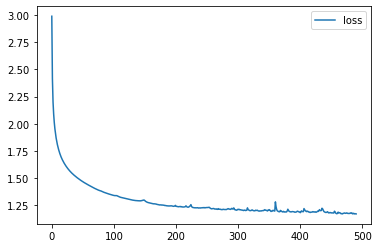

Epoch: 490/500............. Loss: 1.1699


RnnLSTM(
  (emb): Embedding(38, 64)
  (rnn): LSTM(64, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=38, bias=True)
)

In [0]:
dataLoader = to_DataLoader_for_emb_new(text_nums, SEQ_SIZE, token_to_idx, BATCH_SIZE)
char_rnn_lstm = RnnLSTM(dict_size, HIDDEN_DIM, EMB_DIM)
criterion = nn.CrossEntropyLoss()
opt =  torch.optim.Adam(char_rnn_lstm.parameters(), lr=0.002)
train(char_rnn_lstm, criterion, opt, dataLoader, BATCH_SIZE, dict_size, device, EPOCH)

In [49]:
print(generate_sample(char_rnn_lstm, device, "I loved you, and that love, to die refusing,", 300, 1.0))

i loved you, and that love, to die refusing,
  or soul the blown call my somed:
  no state this a maight thy darm'd,
  and such are not rich are beauty's glac
  to do that tout in the belang,
  and fir, one same a bectith know'st i canverlout
  wasten efewers feedis, heave, to then,
  and long yidel


In [48]:
print(generate_sample(char_rnn_lstm, device, "I loved you, and that love, to die refusing,", 300, 2.0))

i loved you, and that love, to die refusing,
  attelie-acherwbel;' in didd, uljutery,
  whis nert, grom'stivail, or-liebd,n sofrwss'd;
  pen hin upon cobksfere remoriedgaty cern you;
  aifit, ih burieswsy, nor which fake frommely.
  for youind old yourien, homif roseve, i've robme; no ahlons he lewn


In [47]:
print(generate_sample(char_rnn_lstm, device, "I loved you, and that love, to die refusing,", 300, 0.5))

i loved you, and that love, to die refusing,
  when more to thy bothed hath him the some me.

  xl

  when have all many to this fairer part,
  and love this a form from the world do the heart,
  that i the to the self-ey their of thy spotieg part,
    as the conceall my still to be the conceard dec


In [46]:
print(generate_sample(char_rnn_lstm, device, "I loved you, and that love, to die refusing,", 300, 0.2))

i loved you, and that love, to die refusing,
  and then i stranger that beauty of the strength
  and that i am of the state with the strange.
    in things in the still the strangely my love's fire to me,
  and the to the should i shall i lies,
  that i think thou art thou art to the store;
  that i


In [45]:
print(generate_sample(char_rnn_lstm, device, "I loved you, and that love, to die refusing,", 300, 0.1))

i loved you, and that love, to die refusing,
  and in the to the shall stay, to my love the strange,
  and i am of the state shall stay
  that the to the shall the constance my heart;
  that i the state of thy self the clupt,
  to the self-ey the state of thy self the clupt,
  to the state of thy se


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

The final loss for LSTM became better, it is predictable behaviour. NN learned more connections and loss became smaller. With smaller temperature, NN better generates real words, but has some problems with stanza structure(depends on strarting line). Maybe because \n are less popular in train. So NN uses them only with less likelihood. With temperature equals to 2.0 NN generates random symbols. Maybe because of 1 error brings to lots of them.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [0]:
torch.save(char_rnn_lstm.state_dict(), 'model')

In [40]:
model = RnnLSTM(dict_size, HIDDEN_DIM, EMB_DIM)
model.load_state_dict(torch.load('model'))
model.eval()

RnnLSTM(
  (emb): Embedding(38, 64)
  (rnn): LSTM(64, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=38, bias=True)
)

In [42]:
model = model.to(device)
print(generate_sample(model, device, "I loved you, and that love", 300, 0.1))

i loved you, and that love thee for my still.

  cxxiii

  i have i form of the same,
  that i am so fair the state shall still.

  cxxxiv

  in in the wills the state of thy self the cloud decay
  the proud love the state shall stay,
  that i am so the state shall stay,
  that i the to time the sta


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)